> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [No-show appointments]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.


### Question(s) for Analysis
   1_‘ScheduledDay’ tells us on what day the patient set up their appointment.
   
   2_ ‘Neighborhood’ indicates the location of the hospital.
   
   3_ ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
   
  4_  Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling
Now we will gather data from the csv file to see some general properties, and see the shape of data ,check if there is missing values or not,we will check too for the duplicates or the unusual data to clean them later in the cleanig process.


In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df=pd.read_csv('noshow-may-2016.csv')
df.head(6)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No


In [3]:
#The number of patients and their charactristics.
df.shape

(110527, 14)

There is a 110527 rows and 14 columns in this dataset.

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [5]:
# To know the location for this row of age -1 to remove it later
df.query('Age == "-1"')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


The min age is -1 and this not ogical, so we will drop this row in the cleaning process

In [6]:
#To know the data types and the missing data (There is no missing Data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There is no Missing Data.

In [7]:
#Check for dublicates
df.duplicated().sum()

0

There is no duplicates

In [8]:
sum(df.duplicated('PatientId'))

48228

In [9]:
sum(df.duplicated(['PatientId','No-show']))

38710

There is 38710 patients with the same id and the same status of(no showing),so we will drop them later.

<a id='cleaning'></a>
## Data Cleaning
Remove the duplicates we found it previously,drop the unnecessary columns,rename some columns and correct some words if it is found to make your dataset clean and ready for exploration.


In [10]:
#To remove duplicated id and no_show for patients
df.drop_duplicates(['PatientId','No-show'],inplace=True)

In [11]:
df.shape

(71817, 14)

There is 71817 rows now instead of 110527

In [12]:
#Removing the -1 value of the age
df.drop(index=99832,inplace=True)

In [13]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,7.181600e+04,7.181600e+04,71816.000000,71816.000000,71816.000000,71816.000000,71816.000000,71816.000000,71816.000000
mean,1.466249e+14,5.666493e+06,36.527501,0.095536,0.195068,0.070959,0.025036,0.020135,0.335566
std,2.544917e+14,7.313083e+04,23.378262,0.293956,0.396256,0.256758,0.156236,0.155338,0.472191
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.175956e+12,5.631622e+06,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.189425e+13,5.672882e+06,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.457487e+13,5.716567e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The row of -1 of Age is dropped

In [14]:
#using rename function to do some changes in the columns names.
df.rename(columns={'AppointmentDay':'Appointment_Day','No-show':'No_show'},inplace=True)
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,Appointment_Day,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [15]:
# I will drop some columns which is not necessary for us in analyzing the dataset.
df.drop(['AppointmentID', 'ScheduledDay'], axis=1, inplace=True)
df.head(1)

,PatientId,Gender,Appointment_Day,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,2.987250e+13,F,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [16]:
df.shape

(71816, 12)

There is12 columns now instead of 14

<a id='eda'></a>
## Exploratory Data Analysis
We cleaned the data and now we are ready to move to exploration and creating visualizations.



<a id='gen'></a>
## Quick view

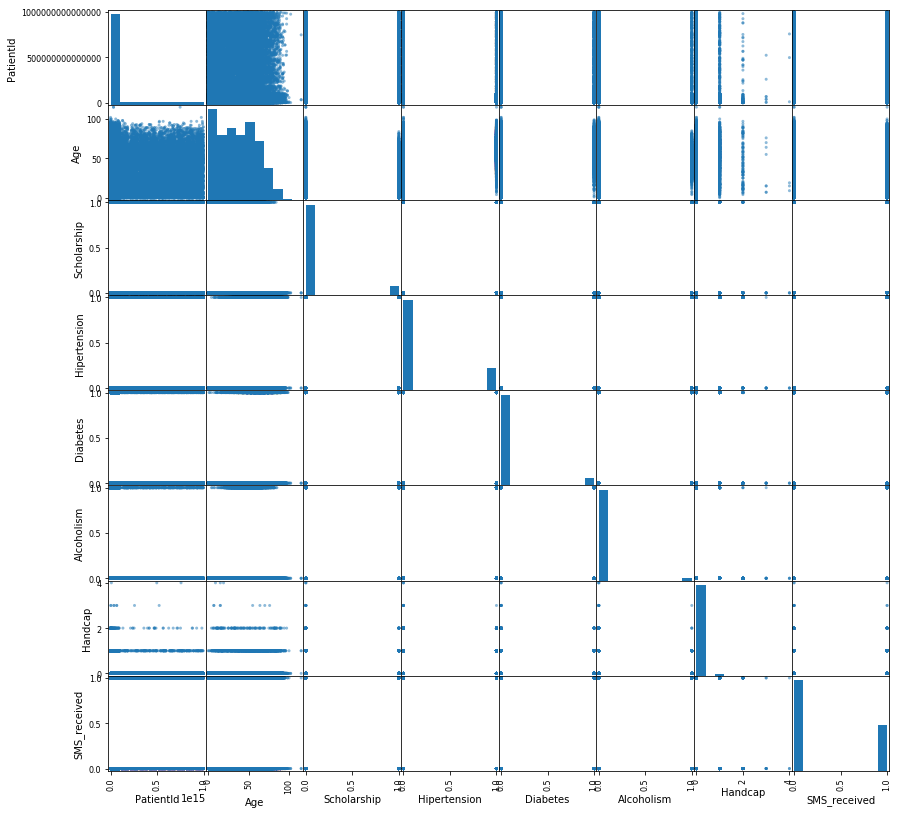

In [17]:
#A scatter plot for all dataset
pd.plotting.scatter_matrix(df, figsize=(14,14));

In [18]:
#dividing the patients into two groups according to showing or no showing
show=df['No_show'] == 'No'
no_show=df['No_show'] == 'Yes'

<a id='inv'></a>
## Investigation to factors that affects the attendance rate for the patients

Is there more females or males patients ?

Text(0.5,1,'Comparison according to Gender')

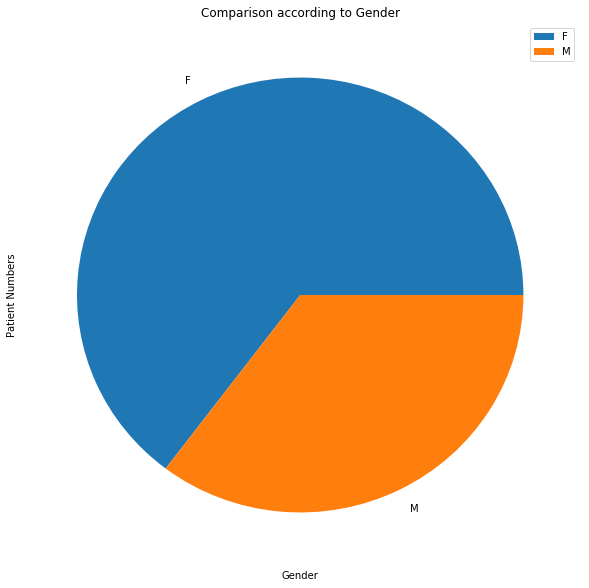

In [19]:
df.groupby('Gender').Gender.count().plot(kind='pie',figsize=(10,10))
plt.legend()
plt.xlabel('Gender')
plt.ylabel('Patient Numbers')
plt.title("Comparison according to Gender")

In [20]:
df.groupby('Gender').Gender.count()

Gender
F    46466
M    25350
Name: Gender, dtype: int64

The number of female patients is almost twice the number of males patients.

Does (Gender) affects the attendance ?

Text(0.5,1,'Comparison according to Gender')

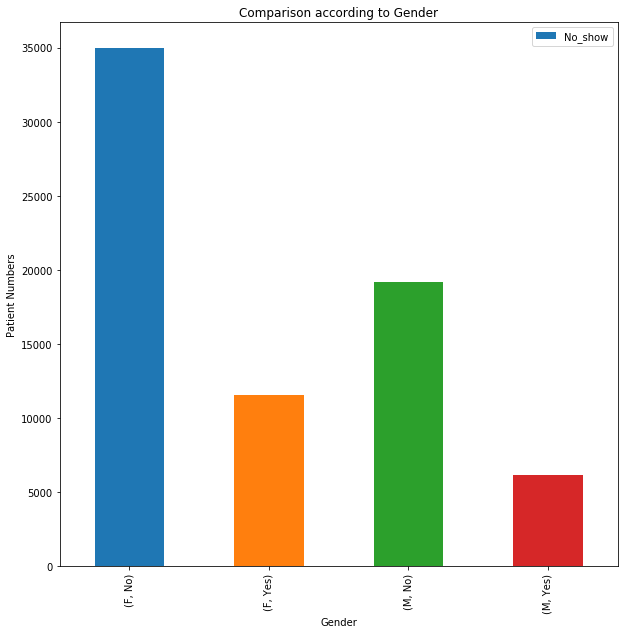

In [21]:
df.groupby('Gender').No_show.value_counts().plot(kind='bar',figsize=(10,10))
plt.legend()
plt.xlabel('Gender')
plt.ylabel('Patient Numbers')
plt.title("Comparison according to Gender")

In [22]:
df.groupby('Gender').No_show.value_counts()

Gender  No_show
F       No         34960
        Yes        11506
M       No         19193
        Yes         6157
Name: No_show, dtype: int64

The females who showed is almost 4 times the females who didn't show and for males: The males who showed is almost 3 times the males who didn't show ,so i think there is no correlation between Gender and the attendance percentage.

Does (Neighbourhood) affects the attendance?

Text(0.5,1,'Comparison according to Neighbourhood')

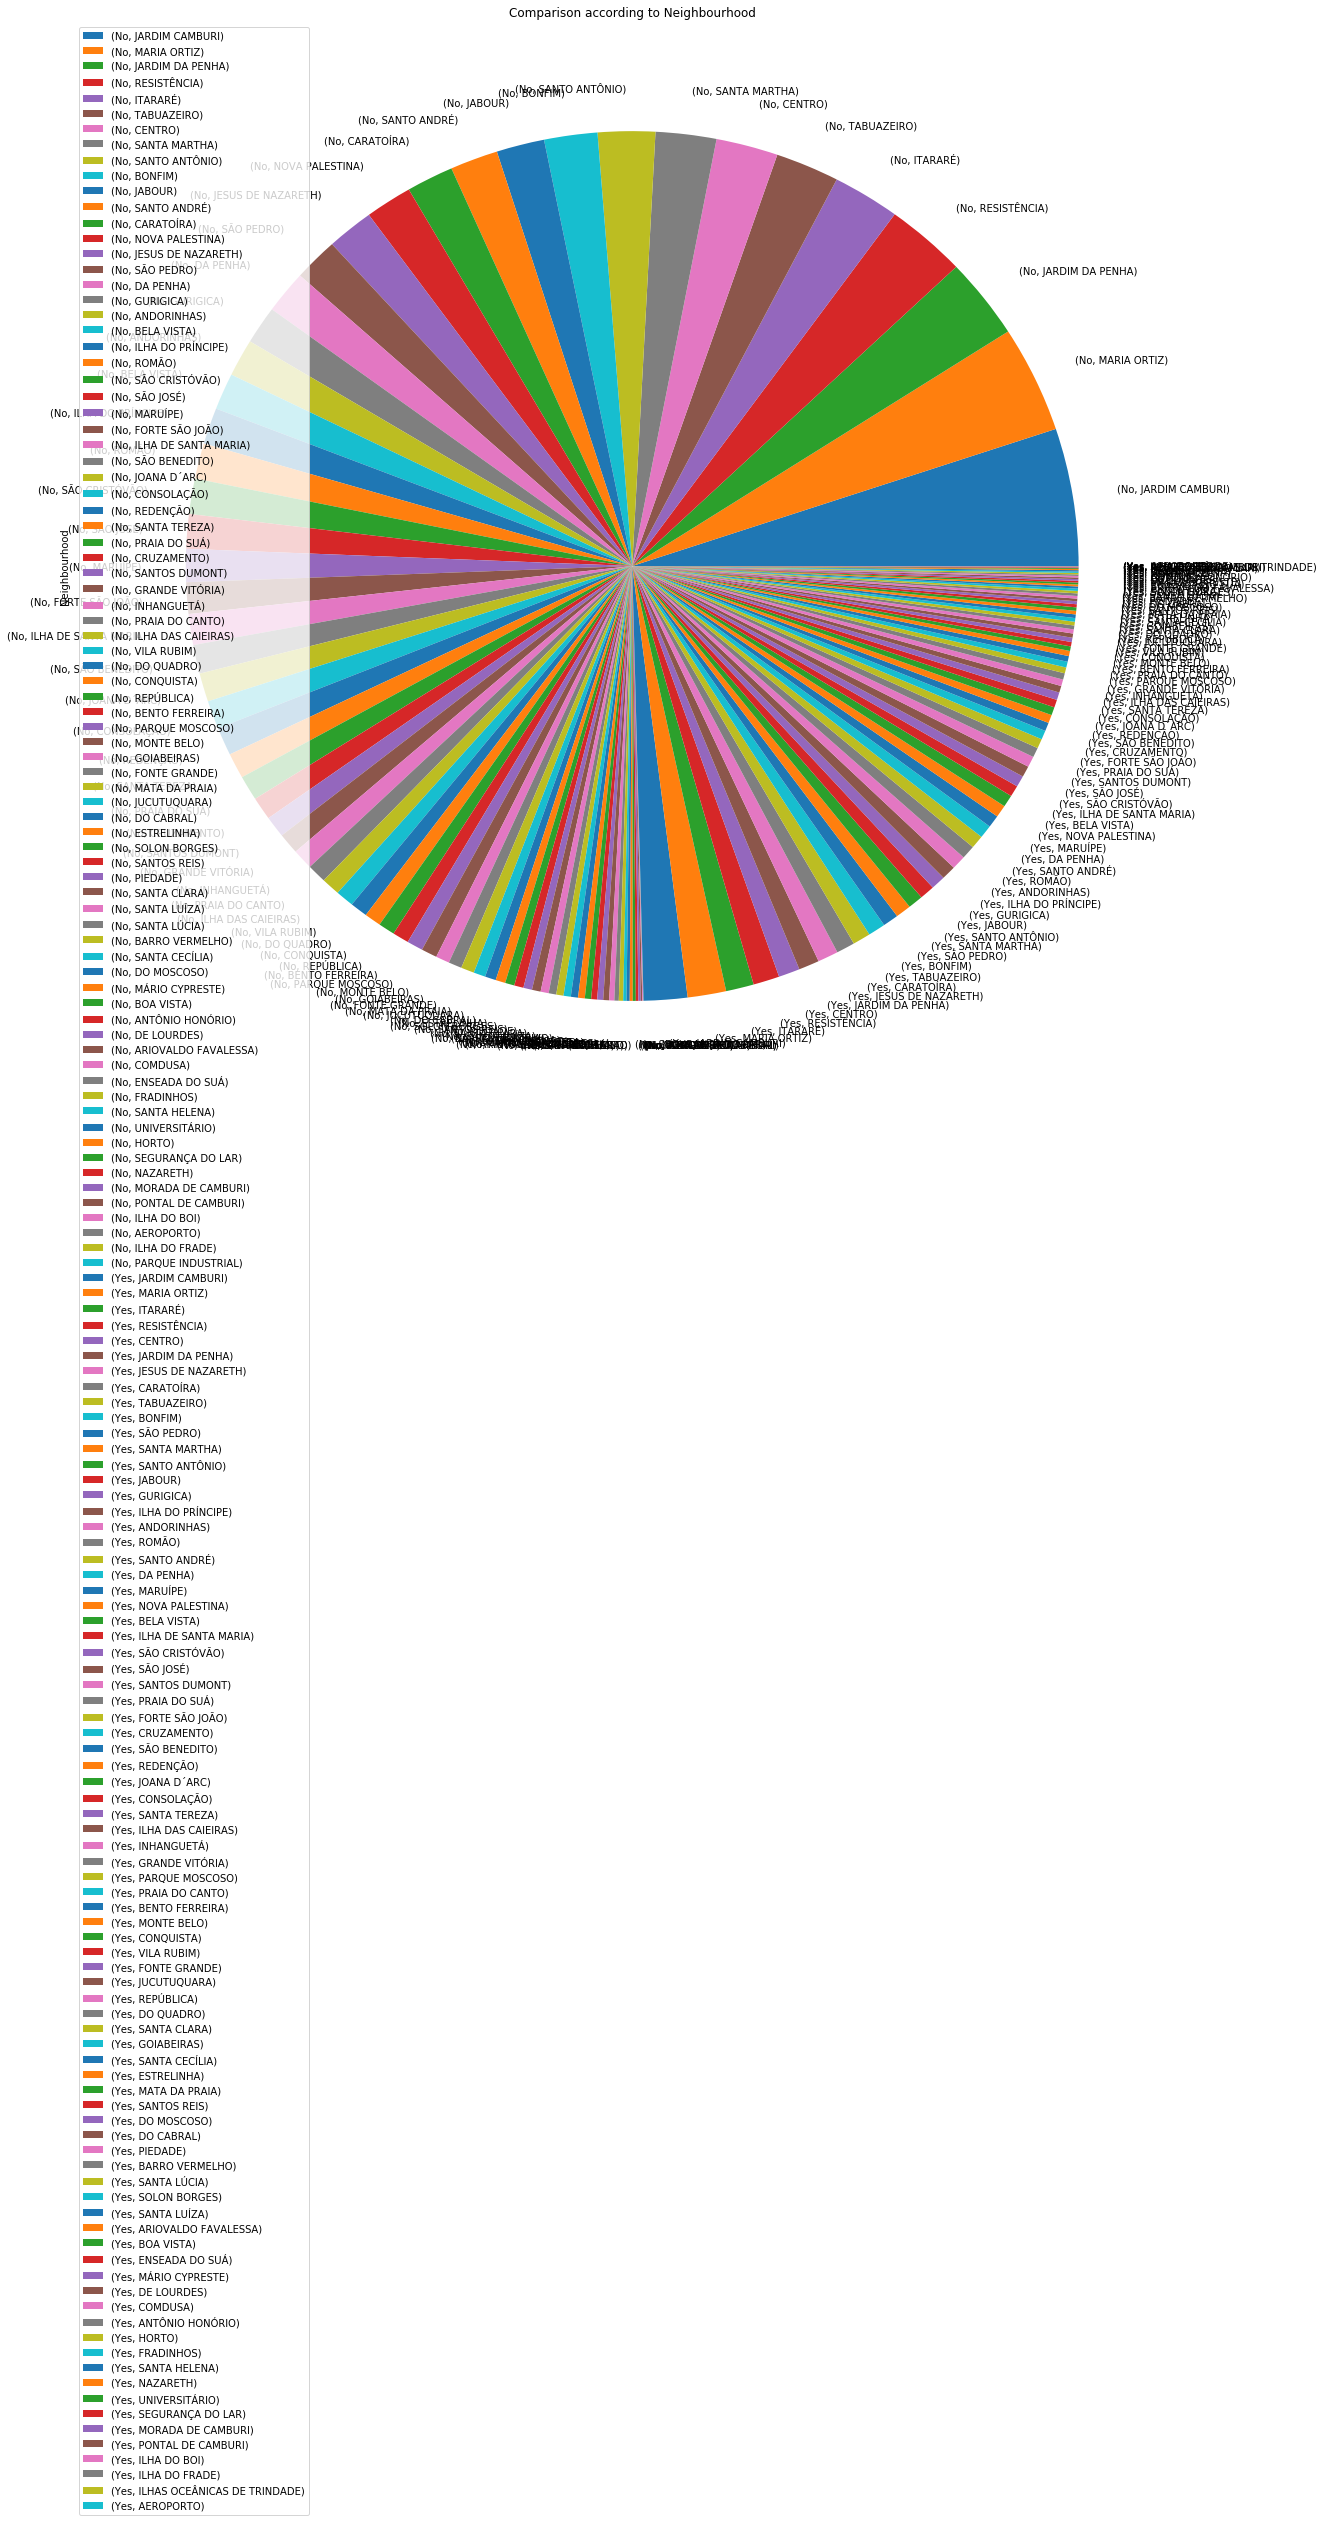

In [23]:
df.groupby('No_show').Neighbourhood.value_counts().plot(kind='pie',figsize=(20,20))
plt.legend()
plt.title('Comparison according to Neighbourhood')

In [24]:
df.groupby('No_show').Neighbourhood.value_counts()

No_show  Neighbourhood              
No       JARDIM CAMBURI                 3666
         MARIA ORTIZ                    2845
         JARDIM DA PENHA                2160
         RESISTÊNCIA                    2098
         ITARARÉ                        1745
         TABUAZEIRO                     1656
         CENTRO                         1610
         SANTA MARTHA                   1577
         SANTO ANTÔNIO                  1488
         BONFIM                         1383
         JABOUR                         1247
         SANTO ANDRÉ                    1246
         CARATOÍRA                      1224
         NOVA PALESTINA                 1221
         JESUS DE NAZARETH              1219
         SÃO PEDRO                      1163
         DA PENHA                       1144
         GURIGICA                       1012
         ANDORINHAS                      997
         BELA VISTA                      975
         ILHA DO PRÍNCIPE                968
         ROMÃO    

It seems like (JARDIM CAMBURI) has the greatest number of showing patients and then (MARIA ORTIZ),so
Neighbourhood has a great effect and strong correlation with the number of patients who is showing.

4_Does receiving SMS or not affects the attendance ?

Text(0.5,1,'Comparison according to SMS_received')

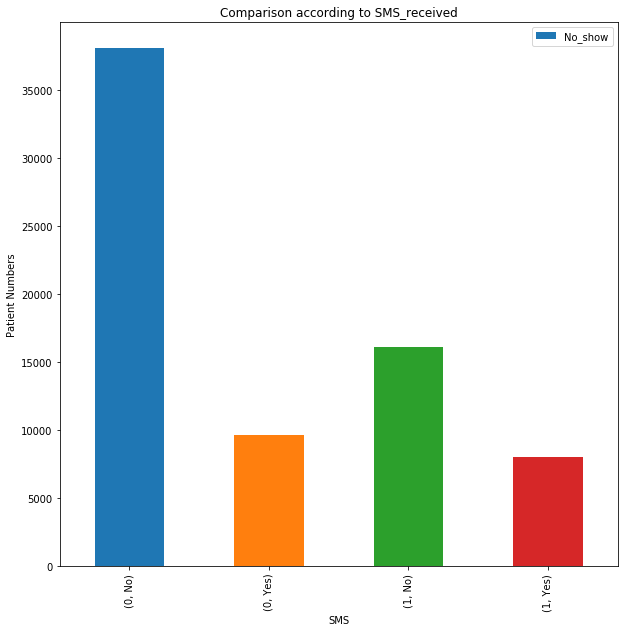

In [25]:
df.groupby('SMS_received').No_show.value_counts().plot(kind='bar',figsize=(10,10))
plt.legend()
plt.xlabel('SMS')
plt.ylabel('Patient Numbers')
plt.title("Comparison according to SMS_received")

In [26]:
#Number of patients who showed or not according to SMS_received
df.groupby('SMS_received').No_show.value_counts()


SMS_received  No_show
0             No         38057
              Yes         9660
1             No         16096
              Yes         8003
Name: No_show, dtype: int64

It is strange to find that patients who didn't recieve SMS is showing more than patients who recieved SMS by (double),so we need to make a review with the SMS campaghin,maybe they are sending SMS to the wrong numbers ,may be they can change the contact method with the patients.

5_Is there a relationship between receiving SMS and the high attendance of specific (Neighbourhood) ?

Text(0.5,1,'Comparison according to Neighbourhood,SMS_receiving')

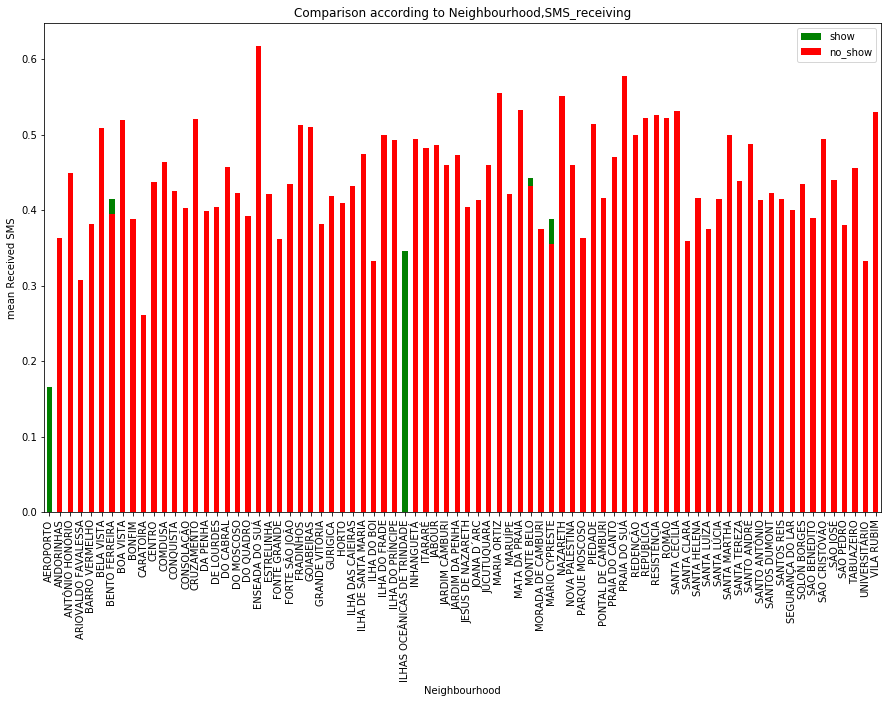

In [27]:
plt.figure(figsize=[15,9]) 
df[show].groupby('Neighbourhood').SMS_received.mean().plot(kind='bar',label='show',color='green')
df[no_show].groupby('Neighbourhood').SMS_received.mean().plot(kind='bar',label='no_show',color='red')
plt.legend()
plt.xlabel('Neighbourhood')
plt.ylabel('mean Received SMS')
plt.title('Comparison according to Neighbourhood,SMS_receiving')

The SMS has response just in 5 neigbourhoods,including two whole neigbourhoods attended when they recieved the SMS , so as we saw previously we need to review the SMS campaign to know why there is a big variance

Is there a large number of diabetic patients?

Text(0.5,1,'Comparison according to Diabetes')

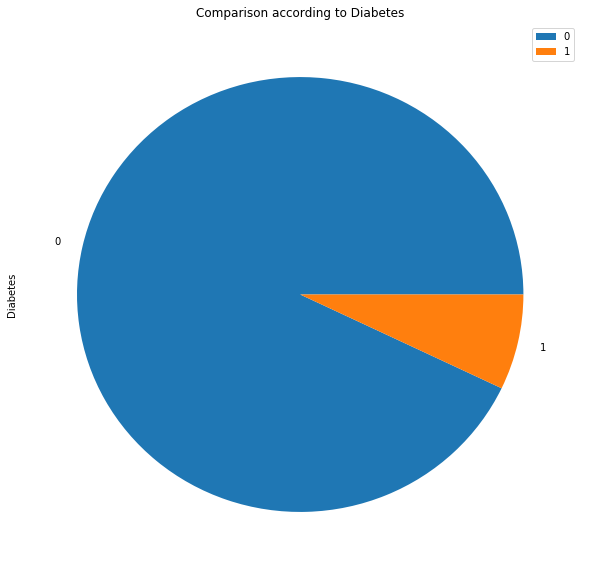

In [28]:
df.groupby('Diabetes').Diabetes.count().plot(kind='pie',figsize=(10,10))
plt.legend()
plt.title("Comparison according to Diabetes")

In [29]:
df.groupby('Diabetes').Diabetes.count()

Diabetes
0    66720
1     5096
Name: Diabetes, dtype: int64

There are almost 13% of patients diabetic.

Is there is a relationship between Diabetic patients and their ages ?

Text(0.5,1,'Comparison according to Diabetes and Age')

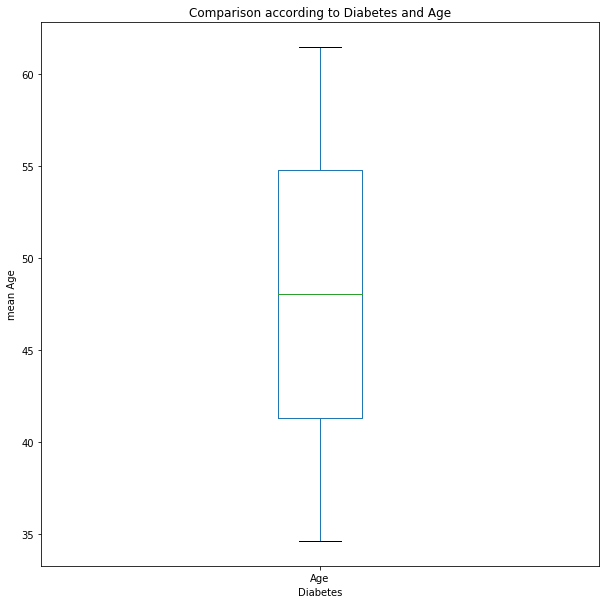

In [30]:
df.groupby('Diabetes').mean().Age.plot(kind='box',figsize=(10,10))
plt.legend()
plt.xlabel('Diabetes')
plt.ylabel('mean Age')
plt.title('Comparison according to Diabetes and Age')

In [31]:
df.groupby('Diabetes').mean().Age

Diabetes
0    34.620069
1    61.500785
Name: Age, dtype: float64

The mean Age of diabetic patients is almost 62 years ,and for non diabetic patients is 35 years.

Does Diabetes affects the attendance or not?

Text(0.5,1,'Comparison according to Diabetes')

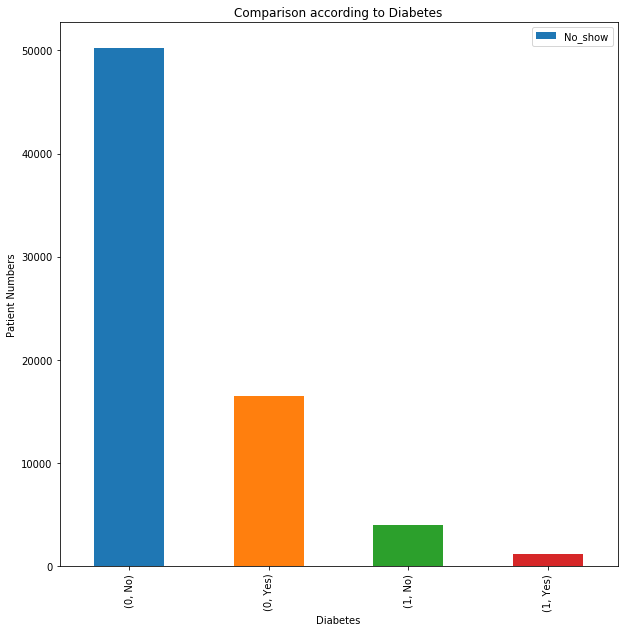

In [32]:
df.groupby('Diabetes').No_show.value_counts().plot(kind='bar',figsize=(10,10))
plt.legend()
plt.xlabel('Diabetes')
plt.ylabel('Patient Numbers')
plt.title("Comparison according to Diabetes")

In [33]:
df.groupby('Diabetes').No_show.value_counts()

Diabetes  No_show
0         No         50207
          Yes        16513
1         No          3946
          Yes         1150
Name: No_show, dtype: int64

I saw there is no clear relationship between diabetic patients and their attendance.

6_Does(scholarship) affects the attendance ?

Text(0.5,1,'Comparison according to scholarship and attendance')

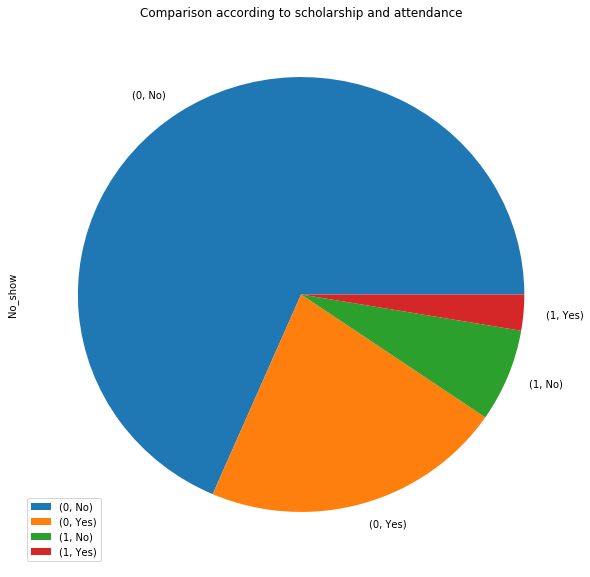

In [34]:
df.groupby('Scholarship').No_show.value_counts().plot(kind='pie',figsize=(10,10))
plt.legend()
plt.title('Comparison according to scholarship and attendance')

In [35]:
df.groupby('Scholarship').No_show.value_counts()

Scholarship  No_show
0            No         49207
             Yes        15748
1            No          4946
             Yes         1915
Name: No_show, dtype: int64

For patients who doesn't have scholarships: the showing customers is threee times the no show customers,
and for patients who have scholarships: the showing customers is just almost twice of the non showing customer ,i expect more patients is coming as they have scholarships,
I think there is a bit relationship between having a scholarship and the attendance as they have higher attendance percentage.

What percentage of people suffer from hipertention ?

Text(0.5,1,'Comparison according to Hipertension')

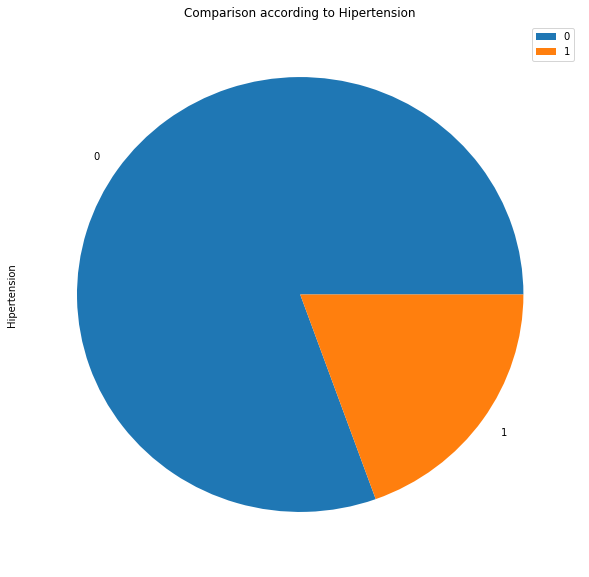

In [36]:
df.groupby('Hipertension').Hipertension.count().plot(kind='pie',figsize=(10,10))
plt.legend()
plt.title("Comparison according to Hipertension")

In [37]:
df.groupby('Hipertension').Hipertension.count()

Hipertension
0    57807
1    14009
Name: Hipertension, dtype: int64

There is almost 25% of the patients suffers from hipertention

7_Does(Hipertension) affects the attendance ?

Text(0.5,1,'Comparison according to Hipertension')

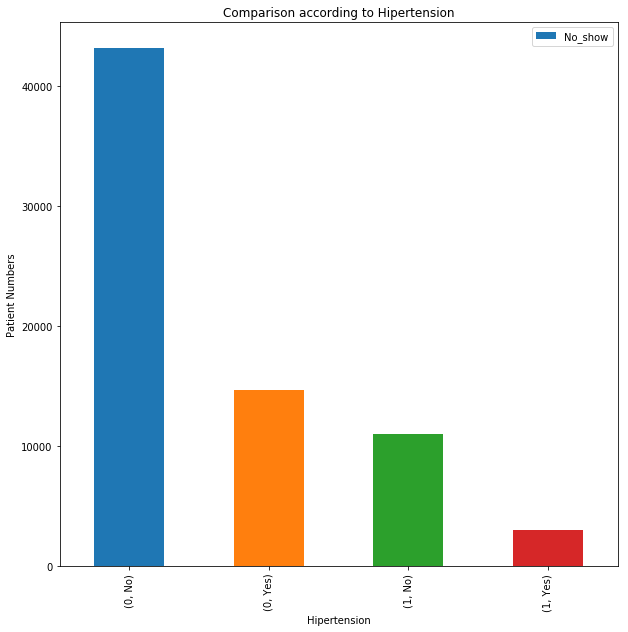

In [38]:
df.groupby('Hipertension').No_show.value_counts().plot(kind='bar',figsize=(10,10))
plt.legend()
plt.xlabel('Hipertension')
plt.ylabel('Patient Numbers')
plt.title("Comparison according to Hipertension")

In [39]:
df.groupby('Hipertension').No_show.value_counts()

Hipertension  No_show
0             No         43163
              Yes        14644
1             No         10990
              Yes         3019
Name: No_show, dtype: int64

For hipertention patients: number of showing is almost 4 times the non showing patients ,
For  non hipertention patients: number of showing is almost 3 times the non showing patients 
I think there is no strong correlation between people has Hipertension and attendance percentage.

Does(Alcoholism) affects the attendance ?

Text(0.5,1,'Comparison according to Alcoholism')

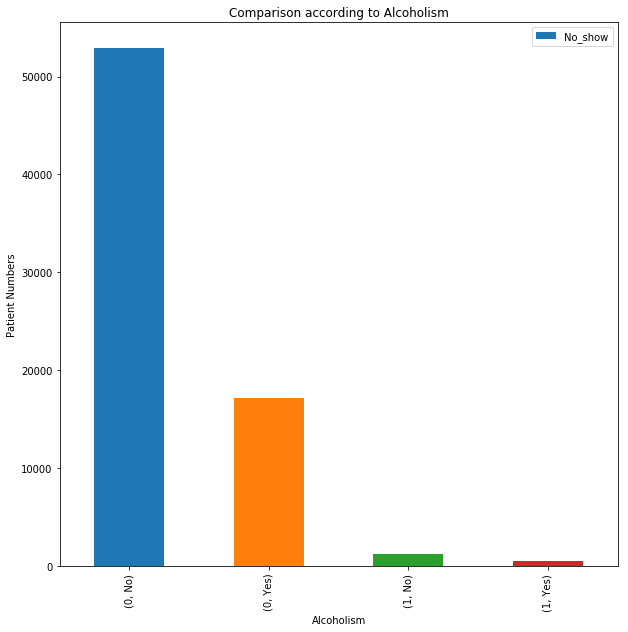

In [40]:
df.groupby('Alcoholism').No_show.value_counts().plot(kind='bar',figsize=(10,10))
plt.legend()
plt.xlabel('Alcoholism')
plt.ylabel('Patient Numbers')
plt.title("Comparison according to Alcoholism")


In [41]:
df.groupby('Alcoholism').No_show.value_counts()

Alcoholism  No_show
0           No         52875
            Yes        17143
1           No          1278
            Yes          520
Name: No_show, dtype: int64

There is a small numer of Alcoholic patients ,There is no clear relationship between Alcoholic patients and attendance percentage.

Does(Handcap) affects the attendance  ?

Text(0.5,1,'Comparison according to Handcap')

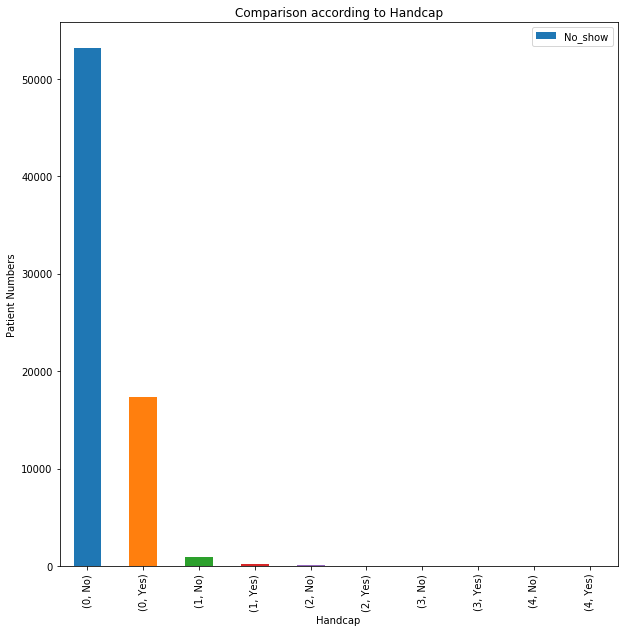

In [42]:
df.groupby('Handcap').No_show.value_counts().plot(kind='bar',figsize=(10,10))
plt.legend()
plt.xlabel('Handcap')
plt.ylabel('Patient Numbers')
plt.title("Comparison according to Handcap")

In [43]:
df.groupby('Handcap').No_show.value_counts()

Handcap  No_show
0        No         53126
         Yes        17385
1        No           931
         Yes          247
2        No            89
         Yes           27
3        No             5
         Yes            3
4        No             2
         Yes            1
Name: No_show, dtype: int64

There is no relationship between handcapped patients and theit attendance

<a id='eda'></a>
## Conclusions
1_The number of female patients is almost twice the number of males patients ,but there is no correlation between Gender and the attendance percentage.

2_ about Neighbouhood : (JARDIM CAMBURI) has the greatest number of showing patients and then (MARIA ORTIZ),so Neighbourhood has a strong correlation with the attendance percentage.

3_About Sms: We need to make a review with the SMS campaghin because we found that patients who didn't recieve SMS is showing more than patients who recieved SMS by (double). 

4_About Diabetic :There are almost 13% of diabetic patients ,but There is no clear correlation between Diabetic patients and theit attendance , and there is a relationship between Diabetic patients and their ages ,more diabetic patients is in older ages than the younger .

5_About Scholarship : There is no clear relationship between attendance and having scholarship.

6_About hipertention :There is almost 25% of the patients suffers from hipertention , and there is no strong correlation between people has Hipertension and attendance percentage.

7_About Handcap and Alcoholism: There is no correlation between(Handcapped,Alcoholic) patients and The attendance percentage.





In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0